Setup and Imports

In [ ]:
# Standard library
import os
import gzip
import json
import re
import pickle
import shutil
from collections import Counter

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    LSTM, Embedding, RepeatVector, TimeDistributed, Dense, Input
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

# Notebook display
from IPython.display import HTML, display

Found GPU at: /device:GPU:0


I0000 00:00:1766937288.043675      55 gpu_device.cc:2019] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766937288.043879      55 gpu_device.cc:2019] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
# Verify GPU
device_name = tf.test.gpu_device_name()
print(f'Found GPU at: {device_name}' if device_name else 'No GPU found. Check Runtime settings.')

**Data Loading & Preprocessing**

In [10]:
def parse(path):
    with gzip.open(path, 'rb') as g:
        for l in g:
            yield json.loads(l)

# Load the dataset
# Ensure reviews_Grocery_and_Gourmet_Food_5.json.gz is uploaded to Colab
data_list = list(parse('Exp-RS/reviews_Grocery_and_Gourmet_Food_5.json.gz'))
df = pd.DataFrame(data_list)[['reviewerID', 'reviewText']]

# Cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df['clean_text'] = df['reviewText'].apply(clean_text)

# Tokenization
MAX_VOCAB = 15000
MAX_LEN = 25
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<UNK>")
tokenizer.fit_on_texts(df['clean_text'])

def encode(texts):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN, padding='post', truncating='post')

X_global = encode(df['clean_text'].values)

**Build & Train the Base Model**

In [11]:
LATENT_DIM = 256

# --- ARCHITECTURE ---
enc_inputs = Input(shape=(MAX_LEN,))
enc_embed = Embedding(MAX_VOCAB, 128)(enc_inputs)
_, state_h, state_c = LSTM(LATENT_DIM, return_state=True)(enc_embed)

dec_inputs = RepeatVector(MAX_LEN)(state_h)
dec_lstm = LSTM(LATENT_DIM, return_sequences=True)(dec_inputs, initial_state=[state_h, state_c])
dec_outputs = TimeDistributed(Dense(MAX_VOCAB, activation='softmax'))(dec_lstm)

base_model = Model(enc_inputs, dec_outputs)
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Train Base Model
print("Training Base Model...")
history = base_model.fit(X_global, np.expand_dims(X_global, -1), epochs=25, batch_size=256)

I0000 00:00:1766937371.512577      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766937371.512803      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training Base Model...
Epoch 1/25


I0000 00:00:1766937378.831345     196 cuda_dnn.cc:529] Loaded cuDNN version 91002


591/591 ━━━━━━━━━━━━━━━━━━━━ 95s 149ms/step - loss: 6.6246
Epoch 2/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - loss: 5.9305
Epoch 3/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 157ms/step - loss: 5.2490
Epoch 4/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 158ms/step - loss: 4.6034
Epoch 5/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 158ms/step - loss: 4.0189
Epoch 6/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 158ms/step - loss: 3.5385
Epoch 7/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 157ms/step - loss: 3.1612
Epoch 8/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 157ms/step - loss: 2.8475
Epoch 9/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 157ms/step - loss: 2.5748
Epoch 10/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - loss: 2.3367
Epoch 11/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 93s 157ms/step - loss: 2.1391
Epoch 12/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - loss: 1.9819
Epoch 13/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - loss: 1.8410
Epoch 14/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - loss: 1.7104
Epoch 15/25
591/591 ━━━━━━

**Save the model and environment**

In [19]:
# Create a fake history object so the saving logic works
class DummyHistory:
    def __init__(self):
        self.history = {'loss': [0.0]} # Placeholder value

history = DummyHistory()

In [23]:
# Save the model and weights
model_file = '/kaggle/working/grocery_base_model_v2.keras'
weights_file = '/kaggle/working/base_weights.weights.h5'
base_model.save(model_file) # Native Keras format
base_model.save_weights(weights_file)

# Save the updated session metadata
state_metadata = {
    'tokenizer': tokenizer,
    'max_len': MAX_LEN,
    'max_vocab': MAX_VOCAB,
    'latent_dim': LATENT_DIM,
    'history': history.history
}
with open('session_metadata.pkl', 'wb') as f:
    pickle.dump(state_metadata, f)



**Personalization Engine**

In [21]:
user_style_bank = {}

def sample_with_temperature(preds, temperature=0.7):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-7) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.argmax(np.random.multinomial(1, preds, 1))


def get_user_recommendation(target_user_id, generic_text):
    # Get user reviews
    user_revs = df[df['reviewerID'] == target_user_id]['clean_text'].values
    X_user = encode(user_revs)
    
    # Clone and Freeze Encoder
    user_model = tf.keras.models.clone_model(base_model)
    user_model.set_weights(base_model.get_weights())
    for layer in user_model.layers[:3]: # Input, Embed, Encoder
        layer.trainable = False
        
    user_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy')
    user_model.fit(X_user, np.expand_dims(X_user, -1), epochs=5, verbose=0)
    
    # Store weights
    user_style_bank[target_user_id] = {
        'decoder': user_model.layers[4].get_weights(),
        'output': user_model.layers[5].get_weights()
    }
    
    # Generate
    preds = user_model.predict(encode([generic_text]))[0]
    words = [tokenizer.index_word.get(sample_with_temperature(p), "") for p in preds]
    return " ".join([w for w in words if w != ""]).replace("<UNK>", "")

In [22]:
## Check the model
test_phrase = "this coffee is very strong and dark"
X_test = pad_sequences(tokenizer.texts_to_sequences([test_phrase]), maxlen=MAX_LEN, padding='post')
preds = base_model.predict(X_test)[0]

# Use a moderate temperature to see variety
words = [tokenizer.index_word.get(sample_with_temperature(p, temperature=0.8), "") for p in preds]
print(f"Reconstructed: {' '.join([w for w in words if w != ''])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Reconstructed: this coffee is very strong and rich


**Testing and Export**

In [27]:
# Test on top users
top_users = df['reviewerID'].value_counts().head(5).index.tolist()
results = []
test_phrase = "this is a very high quality food item with a fresh taste"

for u_id in top_users:
    personalized = get_user_recommendation(u_id, test_phrase)
    results.append({'user_id': u_id, 'original': test_phrase, 'personalized': personalized})

# Export
os.makedirs('export', exist_ok=True)
with open('export/tokenizer.pkl', 'wb') as f: pickle.dump(tokenizer, f)
with open('export/user_styles.pkl', 'wb') as f: pickle.dump(user_style_bank, f)
base_model.save_weights('export/base.weights.h5')
shutil.make_archive('grocery_project', 'zip', 'export')

# Display Table
html = "<table border='1'><tr><th>User</th><th>Personalized Output</th></tr>"
for r in results:
    html += f"<tr><td>{r['user_id']}</td><td>{r['personalized']}</td></tr>"
display(HTML(html + "</table>"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


User,Personalized Output
A3OXHLG6DIBRW8,this is a very high quality style item has a fresh taste
AY12DBB0U420B,this is a very high quality baby exchange with a fresh taste
A2XKJ1KX6XUHYP,this is a very high quality food item has some fresh taste
A1UQBFCERIP7VJ,this is a very high quality food item with a texture taste
AAA0TUKS5VBSA,this is a very high quality food addition with a fresh taste


Save the model files

In [ ]:
# Ensure the export folder has the latest files
shutil.copy('session_metadata.pkl', 'export/session_metadata.pkl')
shutil.make_archive('grocery_final_project', 'zip', 'export')
print("Final project files ready for download: grocery_final_project.zip")

Final project files ready for download: grocery_final_project.zip


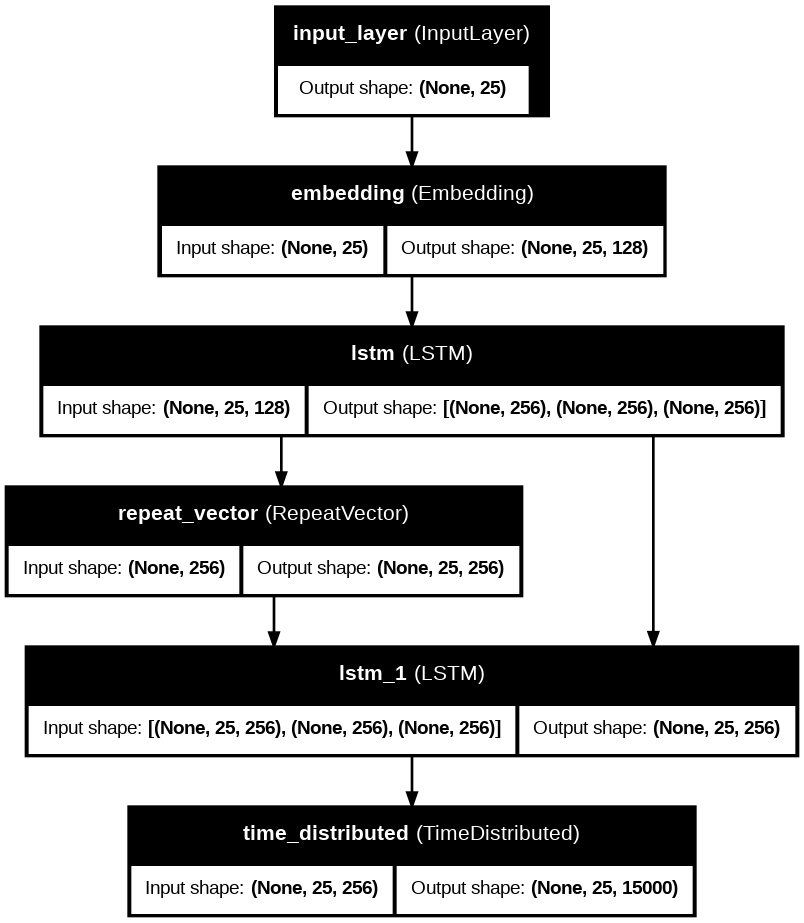

In [ ]:

# This will create a file 'model_architecture.png'
plot_model(
    base_model, 
    to_file='model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB', # 'TB' for Top-to-Bottom; 'LR' for Left-to-Right
    expand_nested=False,
    dpi=96
)

Evaluation 1

In [ ]:


# --- 1. SET UP ENCODER FOR COSINE SIMILARITY ---
# We create a sub-model that only outputs the bottleneck (latent) vector
encoder_model = Model(inputs=base_model.input, outputs=base_model.layers[2].output[1]) # state_h
input_file = '/kaggle/input/inputs/inputs.xlsx'
output_file = '/kaggle/working/tyle_Transfer_Evaluation.xlsx'
def get_latent_vector(text):
    seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_LEN, padding='post')
    return encoder_model.predict(seq, verbose=0)

# --- 2. DEFINE PREFERRED WORDS FOR TOP USERS ---
stop_words = set(['the', 'a', 'and', 'is', 'of', 'to', 'in', 'it', 'i', 'this', 'that', 'with', 'for', 'was', 'as', 'it', 'my', 'have', 'but'])
top_users = df['reviewerID'].value_counts().head(5).index.tolist()

user_profiles = {}
for u_id in top_users:
    user_text = " ".join(df[df['reviewerID'] == u_id]['clean_text'].values).split()
    # Filter out stop words and keep top 100 unique words
    words = [w for w in user_text if w not in stop_words and len(w) > 2]
    user_profiles[u_id] = [w for w, c in Counter(words).most_common(100)]

# --- 3. PRE-TRAIN THE 5 PERSONALIZED MODELS ---
print("Fine-tuning 5 specialized models. Please wait...")
user_models = {}

for u_id in top_users:
    user_revs = df[df['reviewerID'] == u_id]['clean_text'].values
    X_user = encode(user_revs)
    
    # Clone and fine-tune
    m = tf.keras.models.clone_model(base_model)
    m.set_weights(base_model.get_weights())
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy')
    m.fit(X_user, np.expand_dims(X_user, -1), epochs=10, verbose=0, batch_size=4)
    user_models[u_id] = m
    print(f"Model for {u_id} ready.")

# --- 4. PROCESS EXCEL AND EVALUATE ---
input_df = pd.read_excel(input_file) # Ensure your file is named inputs.xlsx
results = []

print("Running experiments...")
for index, row in input_df.iterrows():
    original_text = row.iloc[0] # Assumes first column is the text
    orig_vector = get_latent_vector(original_text)
    
    row_result = {'Input Text': original_text}
    
    for u_id in top_users:
        # A. Generate Personalized Text
        preds = user_models[u_id].predict(encode([original_text]), verbose=0)[0]
        words = [tokenizer.index_word.get(sample_with_temperature(p, 1.2), "") for p in preds]
        output_text = " ".join([w for w in words if w != ""])
        
        # B. Cosine Similarity (Content Preservation)
        out_vector = get_latent_vector(output_text)
        sim = cosine_similarity(orig_vector, out_vector)[0][0]
        
        # C. Preferred Word Count (Style Strength)
        word_count = sum(1 for w in output_text.split() if w in user_profiles[u_id])
        
        # Store for this user
        row_result[f'User_{u_id}_Output'] = output_text
        row_result[f'User_{u_id}_Similarity'] = round(float(sim), 4)
        row_result[f'User_{u_id}_StyleWords'] = word_count
        
    results.append(row_result)

# --- 5. EXPORT RESULTS ---
output_table = pd.DataFrame(results)
output_table.to_excel(output_file, index=False)
print(f"Evaluation Complete! File saved as {output_file}")

Fine-tuning 5 specialized models. Please wait...
Model for A3OXHLG6DIBRW8 ready.
Model for AY12DBB0U420B ready.
Model for A2XKJ1KX6XUHYP ready.
Model for A1UQBFCERIP7VJ ready.
Model for AAA0TUKS5VBSA ready.
Running experiments...
Evaluation Complete! File saved as Style_Transfer_Evaluation.xlsx


Evaluation - long

In [ ]:
output_file_long = '/kaggle/working/tyle_Transfer_Evaluation_long.xlsx'
def process_long_input(text, model, tokenizer, max_len, temp=1.2):
    # 1. Segment by sentence (using regex to split on . ! or ?)
    sentences = re.split(r'(?<=[.!?]) +', text)
    styled_sentences = []
    total_sim = 0
    
    for sentence in sentences:
        if len(sentence.strip()) < 2: continue
        
        # 2. Encode and Predict for each segment
        seq = pad_sequences(tokenizer.texts_to_sequences([sentence]), maxlen=max_len, padding='post')
        preds = model.predict(seq, verbose=0)[0]
        
        # 3. Sample words
        words = []
        for p in preds:
            idx = sample_with_temperature(p, temp)
            if idx == 0: break
            word = tokenizer.index_word.get(idx, "")
            if word: words.append(word)
        
        styled_segment = " ".join(words)
        styled_sentences.append(styled_segment)
        
        # 4. Calculate similarity for this segment
        orig_vec = encoder_model.predict(seq, verbose=0)
        styled_seq = pad_sequences(tokenizer.texts_to_sequences([styled_segment]), maxlen=max_len, padding='post')
        styled_vec = encoder_model.predict(styled_seq, verbose=0)
        total_sim += cosine_similarity(orig_vec, styled_vec)[0][0]

    # 5. Reassemble
    full_output = " ".join(styled_sentences)
    avg_sim = total_sim / len(styled_sentences) if styled_sentences else 0
    return full_output, avg_sim


#batch version
def process_long_input_batched(text, model, tokenizer, max_len, temp=1.2):
    # 1. Segment text into sentences
    sentences = [s.strip() for s in re.split(r'(?<=[.!?]) +', text) if len(s.strip()) > 2]
    if not sentences: return "", 0
    
    # 2. Prepare Batch for GPU
    seqs = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=max_len, padding='post')
    
    # 3. Batch Prediction (Much faster!)
    all_preds = model.predict(seqs, verbose=0, batch_size=len(sentences))
    
    styled_segments = []
    total_sim = 0
    
    # 4. Decode the Batch
    for i, preds in enumerate(all_preds):
        words = []
        for p in preds:
            idx = sample_with_temperature(p, temp)
            if idx == 0: break
            word = tokenizer.index_word.get(idx, "")
            if word: words.append(word)
        
        styled_segment = " ".join(words)
        styled_segments.append(styled_segment)
        
        # 5. Calculate Similarity using the Latent Vectors already computed
        # (Assuming encoder_model is also batched or we do it separately)
        orig_vec = encoder_model.predict(seqs[i:i+1], verbose=0)
        styled_seq = pad_sequences(tokenizer.texts_to_sequences([styled_segment]), maxlen=max_len, padding='post')
        styled_vec = encoder_model.predict(styled_seq, verbose=0)
        total_sim += cosine_similarity(orig_vec, styled_vec)[0][0]

    return " ".join(styled_segments), total_sim / len(sentences)
    
# --- UPDATED EXPERIMENT LOOP ---
results = []
for index, row in input_df.iterrows():
    long_input = str(row.iloc[0])
    row_result = {'Input Text': long_input[:100] + "..."} # Preview for table
    
    for u_id in top_users:
        # Process the long text through the segmentation policy
        #output_text, avg_sim = process_long_input(long_input, user_models[u_id], tokenizer, MAX_LEN)
        output_text, avg_sim = process_long_input_batched(long_input, user_models[u_id], tokenizer, MAX_LEN)
        
        # Style word count (calculated on the whole reassembled text)
        word_count = sum(1 for w in output_text.split() if w in user_profiles[u_id])
        
        row_result[f'User_{u_id}_Output'] = output_text
        row_result[f'User_{u_id}_Similarity'] = round(avg_sim, 4)
        row_result[f'User_{u_id}_StyleWords'] = word_count
        
    results.append(row_result)

# --- 5. EXPORT RESULTS ---
output_table = pd.DataFrame(results)
output_table.to_excel(output_file_long, index=False)
print(f"Evaluation Complete! File saved as {output_file_long}")